In [1]:
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
import h5py
from src.generators import *
import time
from matplotlib import pyplot as plt
np.random.seed(0)

In [2]:
N = [10,100,200,300,500]
#N = [10]

In [5]:
generator = F1()
for item in N:
    generator.create_dataset(item,f"f1_{item}")

In [4]:
def is_leaf(name, node):
    """Check if a node is a dataset (leaf)."""
    return isinstance(node, h5py.Dataset)

def find_leaf_datasets(hdf5_file):
    """Find and return paths to all leaf datasets in an HDF5 file."""
    leaf_datasets = []

    # Traverse the HDF5 file
    hdf5_file.visititems(lambda name, node: leaf_datasets.append(name) if is_leaf(name, node) else None)
    
    return leaf_datasets

def string_with_most_char(strings, char):
    # Initialize variables to track the string with the most occurrences
    max_count = 0
    result_string = ""

    # Iterate through the list of strings
    for s in strings:
        # Count occurrences of the specified character in the current string
        count = s.count(char)
        
        # Update if the current string has more occurrences
        if count > max_count:
            max_count = count
            result_string = s

    return result_string

# HDF5

In [18]:
t = []
t2 = []
t3 = []
t4 = []
t5 = []
for item in N:
    #start_time = time.time()
    with h5py.File(f'h5py_{item}.h5', 'r', driver="core") as f:
        #print(string_with_most_char(find_leaf_datasets(f),"/"))
        #print(find_leaf_datasets(f))
        path = string_with_most_char(find_leaf_datasets(f),"/")
        start_time = time.time()
        data = f[path][:]
        #data = f["example_0"]
        #data = f["example_0/image_feature/image1/boundingbox_feature/bb1/bbox"]
        end_time = time.time()
    t5.append(end_time-start_time)

In [214]:
from tqdm import tqdm
t_load = []
t_manipulate = []
iterations = 100

for item in N:
    tmp_load = []
    tmp_manipulate = []
    for j in tqdm(range(iterations)):
        ### LOADING ###
        st_time = time.time()
        with h5py.File(f'h5py_{item}.h5', 'r', driver="core") as f:
            en_time = time.time()
            ### ------ ###
            tmp_load.append(en_time - st_time)
            path = string_with_most_char(find_leaf_datasets(f),"/")
            start_time = time.time()
            ### MANIPULATION ###
            def get_all_image_datasets():
                image_datasets = []                
                def visit_func(name, obj):
                    if isinstance(obj, h5py.Dataset) and name.endswith('/image_1_feature/image'):
                        new_obj = np.transpose(obj)   
                        new_obj = np.square(new_obj)
                        new_obj = np.exp(new_obj)
                        new_obj = np.transpose(new_obj)
                        image_datasets.append(new_obj[:])
                f.visititems(visit_func)
                return np.array(image_datasets)
            image_ds = get_all_image_datasets()
            ### ----------- ###
            end_time = time.time()
            tmp_manipulate.append(end_time-start_time)
    t_load.append(sum(tmp_load) / len(tmp_load))
    t_manipulate.append(sum(tmp_manipulate) / len(tmp_manipulate))

np.save("t_load_h5",t_load)
np.save("t_manipulate_h5",t_manipulate)


100%|██████████| 100/100 [11:10<00:00,  6.70s/it]


In [26]:
with h5py.File(f'h5py_{10}.h5', 'r', driver="core") as f:       
    print(find_leaf_datasets(f))

['example_0/image_feature/image1/boundingbox_feature/bb1/bbox', 'example_0/image_feature/image1/boundingbox_feature/bb1/image_1_feature/image', 'example_0/image_feature/image1/boundingbox_feature/bb2/bbox', 'example_0/image_feature/image1/boundingbox_feature/bb3/bbox', 'example_0/image_feature/image1/boundingbox_feature/bb3/label_feature/label', 'example_0/image_feature/image1/image', 'example_0/image_feature/image2/boundingbox_feature/bb4/bbox', 'example_0/image_feature/image2/boundingbox_feature/bb5/bbox', 'example_0/image_feature/image2/image', 'example_0/image_feature/image3/image', 'example_0/image_feature/image3/text_1_feature/text', 'example_0/text_feature/text', 'example_1/image_feature/image1/boundingbox_feature/bb1/bbox', 'example_1/image_feature/image1/boundingbox_feature/bb1/image_1_feature/image', 'example_1/image_feature/image1/boundingbox_feature/bb2/bbox', 'example_1/image_feature/image1/boundingbox_feature/bb3/bbox', 'example_1/image_feature/image1/boundingbox_feature/

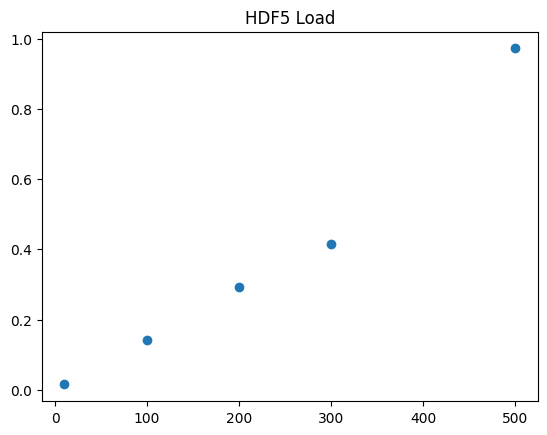

In [41]:
plt.title("HDF5 Load")
plt.scatter(N,t_load)

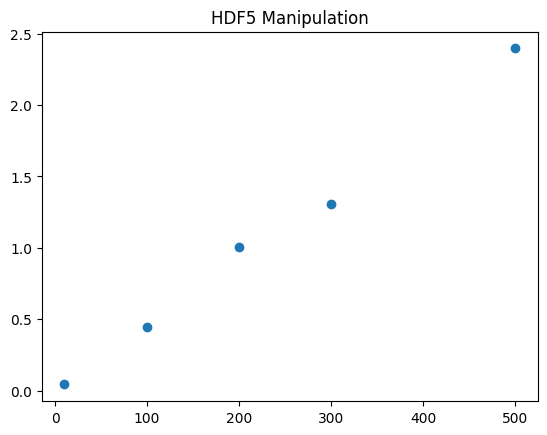

In [42]:
plt.title("HDF5 Manipulation")
plt.scatter(N,t_manipulate)

# Arrow

In [211]:
from tqdm import tqdm
t_load_arrow = []
t_manipulate_arrow = []
iterations = 100

for item in N:
    tmp_load = []
    tmp_manipulate = []
    for j in tqdm(range(iterations)):
        st_time = time.time()
        ### LOADING ###
        table = pq.read_table(f'parquet_{item}.parquet')
        ### ------- ###
        en_time = time.time()
        tmp_load.append(en_time - st_time)
          
        start_time = time.time()
        ### MANIPULATION ###
        
        #oggetto = table["image_feature"].chunk(0)[0][0]["boundingbox_feature"][0]["image_1_feature"][0]["image"]
        #shape = table["image_feature"].chunk(0)[0][0]["boundingbox_feature"][0]["image_1_feature"][0]["shape"]
        #shape = tuple(int(x.as_py()) for x in shape.values)
        #tensor = np.frombuffer(oggetto.as_buffer()).reshape(shape)

        #oggetti = table.column("image_feature").chunk(0).values.field("boundingbox_feature").values.field("image_1_feature").values.field("image")
        #shape =  table.column("image_feature").chunk(0).values.field("boundingbox_feature").values.field("image_1_feature").values.field("shape")
        #shape = tuple(int(shape.as_py()))
        oggetti = np.array(table.column("image_feature").chunk(0).values.field("boundingbox_feature").values.field("image_1_feature").values.field("image").to_pylist())
        image_numpy = np.frombuffer(oggetti, dtype=np.float64).reshape(-1, 3, 125, 125)
        new_obj = np.transpose(image_numpy,axes=(0,3,2,1))   
        new_obj = np.square(new_obj)
        new_obj = np.exp(new_obj)
        new_obj = np.transpose(new_obj,axes=(0,3,2,1))
        ### ----------- ###
        end_time = time.time()
        tmp_manipulate.append(end_time-start_time)
            
    t_load_arrow.append(sum(tmp_load) / len(tmp_load))
    t_manipulate_arrow.append(sum(tmp_manipulate) / len(tmp_manipulate))

    np.save("t_load_arrow",t_load_arrow)
    np.save("t_manipulate_arrow",t_manipulate_arrow)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:51<00:00,  3.51s/it]


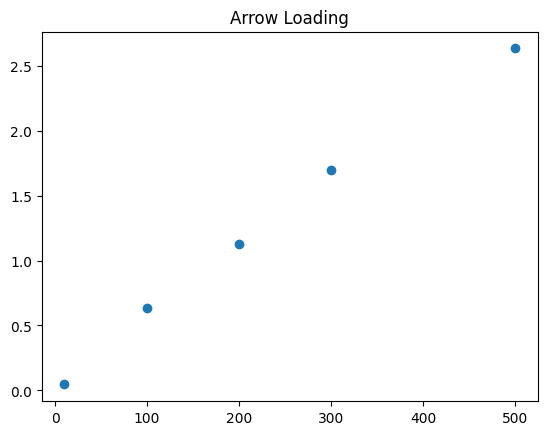

In [212]:
plt.title("Arrow Loading")
plt.scatter(N,t_load_arrow)

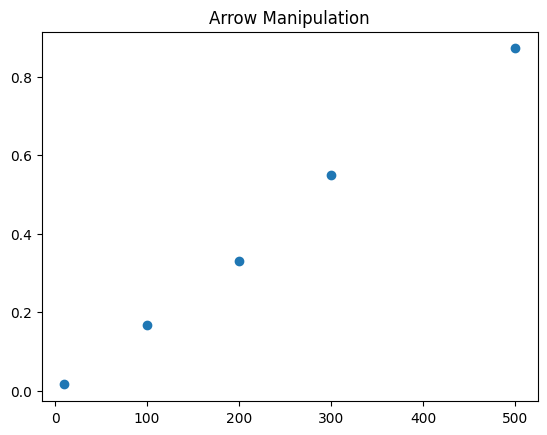

In [213]:
plt.title("Arrow Manipulation")
plt.scatter(N,t_manipulate_arrow)

## Confronto

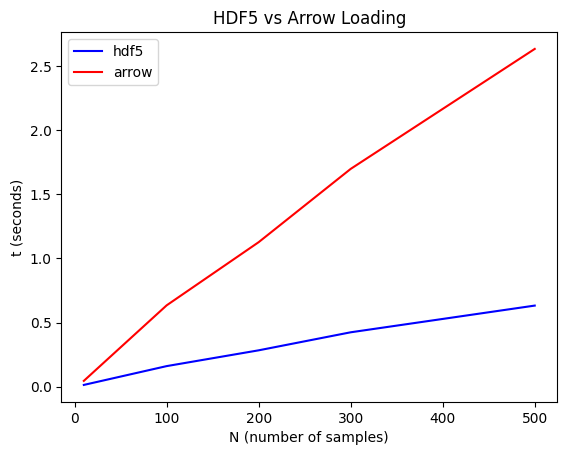

In [215]:
plt.title("HDF5 vs Arrow Loading")
plt.plot(N, t_load, label="hdf5", color='blue')

# Create the second plot
plt.plot(N, t_load_arrow, label="arrow", color='red')

# Add a legend
plt.legend()

# Add titles and labels
plt.xlabel("N (number of samples)")
plt.ylabel("t (seconds)")

# Show the plot
plt.show()

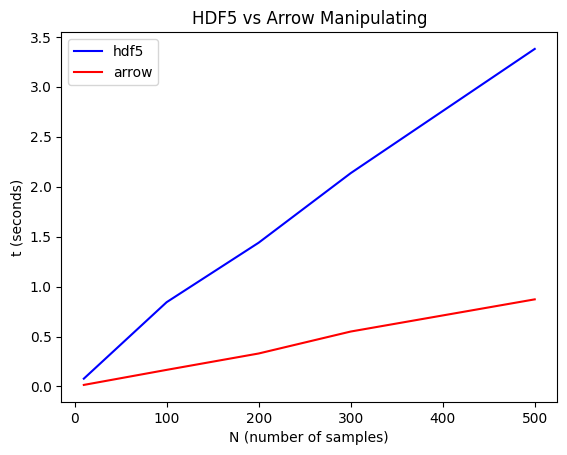

In [216]:
plt.title("HDF5 vs Arrow Manipulating")
plt.plot(N, t_manipulate, label="hdf5", color='blue')

# Create the second plot
plt.plot(N, t_manipulate_arrow, label="arrow", color='red')

# Add a legend
plt.legend()

# Add titles and labels
plt.xlabel("N (number of samples)")
plt.ylabel("t (seconds)")

# Show the plot
plt.show()